### Forecasting Crime in Chicago Using Exponential Smoothing

Author: Joshua Weber

The goal this project is to explore the Chicago crime dataset and forecast crime using the publicly available crime dataset. This dataset is availble from: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/ 

In [1]:
#import the appropriate libraries
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from collections import defaultdict
from matplotlib import pyplot
import os
import warnings # `do not disturbe` mode
warnings.filterwarnings('ignore')
from statsmodels.tsa.api import ExponentialSmoothing, seasonal_decompose
from joblib import Parallel
from joblib import delayed
from multiprocessing import cpu_count
import math
import itertools
import bq_helper
from bq_helper import BigQueryHelper
import json
from google.cloud import storage, bigquery
from google.oauth2 import service_account
from operator import itemgetter

In [2]:
#Set environment variable called "GOOGLE_APPLICATION_CREDENTIALS" to your serrvice account key for authentication
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/jweber6/Documents/Chi_crime/google_account_key.json'

In [3]:
#Test authentication - from: https://cloud.google.com/docs/authentication/getting-started

def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)
    
implicit()

[]


In [4]:
chicago_crime = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="chicago_crime")
bq_assistant = BigQueryHelper("bigquery-public-data", "chicago_crime")
bq_assistant.table_schema("crime") #View a table containing the variable plus descritions

,name,type,mode,description
0,unique_key,INTEGER,REQUIRED,Unique identifier for the record.
1,case_number,STRING,NULLABLE,The Chicago Police Department RD Number (Recor...
2,date,TIMESTAMP,NULLABLE,Date when the incident occurred. this is somet...
3,block,STRING,NULLABLE,The partially redacted address where the incid...
4,iucr,STRING,NULLABLE,The Illinois Unifrom Crime Reporting code. Thi...
5,primary_type,STRING,NULLABLE,The primary description of the IUCR code.
6,description,STRING,NULLABLE,"The secondary description of the IUCR code, a ..."
7,location_description,STRING,NULLABLE,Description of the location where the incident...
8,arrest,BOOLEAN,NULLABLE,Indicates whether an arrest was made.
9,domestic,BOOLEAN,NULLABLE,Indicates whether the incident was domestic-re...


In [5]:
query_whole = '''
SELECT * FROM `bigquery-public-data.chicago_crime.crime`
'''

bq_assistant.estimate_query_size(query_whole)

1.4051875928416848

Querying the entire dataset would cost about 1.4 GB. However, not all of the variables will be used in this time series analysis and so we will create a query produces an object with containing variables we will use.

In [6]:
query_use = '''
SELECT date, description FROM `bigquery-public-data.chicago_crime.crime`
'''

bq_assistant.estimate_query_size(query_use)

0.1739480784162879

By querying only the variables that are actually needed for this time-series modeling exercise, we can reduce the cost to about 170 MB. 

In [7]:
crime_df = bq_assistant.query_to_pandas_safe(query_use)

In [8]:
crime_df.head()

,date,description
0,2005-01-01 00:00:00+00:00,FINANCIAL ID THEFT:$300 &UNDER
1,2005-03-05 23:00:00+00:00,CRIMINAL SEXUAL ABUSE
2,2015-01-01 00:00:00+00:00,SEX ASSLT OF CHILD BY FAM MBR
3,2010-03-25 12:00:00+00:00,FINANCIAL IDENTITY THEFT $300 AND UNDER
4,2004-06-01 00:00:00+00:00,PREDATORY


In [9]:
pandas_profiling.ProfileReport(crime_df, minimal=False)

After profiling the data we can see that there is no missing data in the date column or the description column, which are the two columns of interest when building the exponential smoothing model. Since no data was missing, I will simply ignore the missing values for now. 

However, <b>description</b> is a highly cardinal variable with 524 distinct values, and so forecasting each crime type indivudually would produce overwhelming results. Instead, I grouped the data into violent and non_violent crimes based on their description to reduce cardinality. 

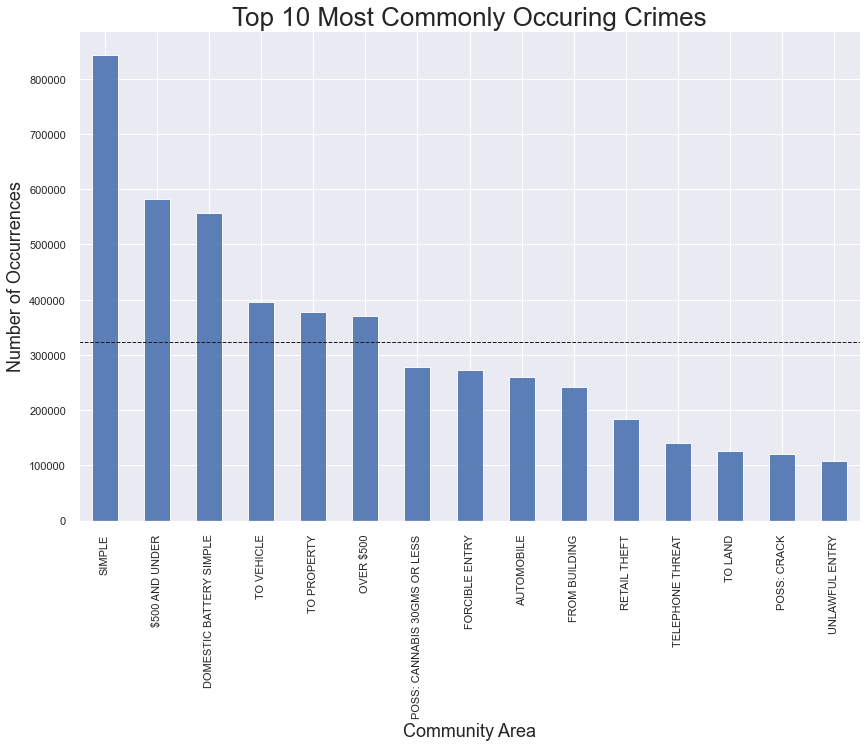

In [10]:
community_area_count = crime_df['description'].value_counts()
sns.set(style="darkgrid")
community_area_count = community_area_count[:15]
community_area_count[:15].plot(kind = 'bar', alpha=0.9, figsize=(14, 9))
plt.title('Top 10 Most Commonly Occuring Crimes', fontsize = 26)
plt.axhline(community_area_count.mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Number of Occurrences', fontsize=18)
plt.xlabel('Community Area', fontsize=18)
plt.show()

The top 15 most commonly occuring crimes are nonviolent.

In [11]:
#generate list of words that indicate crime was likely violent
words =[] 
[words.append(i.split()) for i in list(set(crime_df['description']))] 
key_words = [i for sublist in words for i in sublist]
violent_words = ['ABDUCTION', 'ABDUCTION/STRANGER', 'ABUSE', 'ABUSE/NEGLECT', 'ABUSE/NEGLECT:', 'AGG', 'AGG.', 'AGG:', 'AGGRAVATED', 'AGGRAVATED:', 'AGGRAVATED:KNIFE/CUTTING', 'AMMUNITION', 'ARMED', 'ARMED-HANDGUN', 'ARMED-KNIFE/CUT', 'ARMED-OTHER', 'ARMED:', 'ARMED:KNIFE/CUTTING', 'ARSON', 'ARSON/EXPLOSIVE', 'ARSONIST', 'ARSONIST:', 'ASSAULT', 'ASSLT', 'BATTERY', 'BATTERY:', 'BOMB', 'BULLETS', 'CUTTING', 'DISCHARGE', 'EXPLOSIVE', 'EXPLOSIVE/INCENDIARY', 'FIREARM', 'FIST', 'FISTS', 'GUN', 'HANDGUN', 'HANDS', 'HANDS', 'HANDS/FIST/FEET', 'HOMICIDE', 'INCENDIARY', 'INJURY', 'KIDNAPPING', 'KNIFE', 'KNIFE/CUT', 'KNIFE/CUTTING', 'LIFE', 'LIFE/HEALTH', 'MANSLAUGHTER', 'MURDER', 'MUT:', 'MUT:HANDGUN', 'MUT:KNIFE/CUTTING', 'MUT:OTH', 'PIERCING', 'PO:KNIFE/CUT', 'PRO.EMP:KNIFE/CUTTING', 'RIFLE', 'STRONGARM', 'STRONGARM:', 'VIOLENCE', 'VIOLENT', 'WEAP', 'WEAPON', 'WEAPONS']
violent_word_str = '|'.join(violent_words)
x = crime_df[crime_df["description"].str.contains(violent_word_str, na=False)]

In [12]:
#Using the list from above add dummy variable to the crime dataset to indicate whether or not the crime was violent
violent_indices = x.index
crime_df.loc[violent_indices, 'is_violent'] = 1
crime_df['is_violent'].fillna(0, inplace = True)

In [13]:
crime_df.head()

,date,description,is_violent
0,2005-01-01 00:00:00+00:00,FINANCIAL ID THEFT:$300 &UNDER,0.0
1,2005-03-05 23:00:00+00:00,CRIMINAL SEXUAL ABUSE,1.0
2,2015-01-01 00:00:00+00:00,SEX ASSLT OF CHILD BY FAM MBR,1.0
3,2010-03-25 12:00:00+00:00,FINANCIAL IDENTITY THEFT $300 AND UNDER,0.0
4,2004-06-01 00:00:00+00:00,PREDATORY,0.0


In [14]:
#Convert dataframe to time series

def to_timeseries(df):
    df = df[['date']] 
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%m/%d/%Y')
    df1 = (df.set_index(pd.to_datetime(df['date']))).resample("M").count() #convience method to perfrom functions on ts data
    df1 = df1.rename(columns = {'date': 'counts'})
    return(df1)


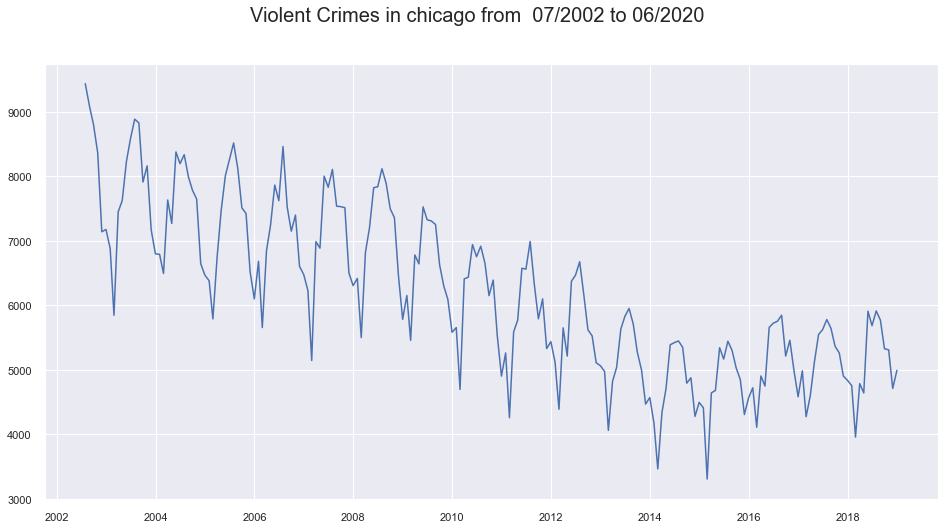

In [15]:
#Plot the violent crime data
violent_df = crime_df[crime_df['is_violent'] == 1]
violent_ts_test = to_timeseries(violent_df).loc['2002-07-31':'2020-06-30']
violent_ts_train = to_timeseries(violent_df).loc['2002-07-31':'2018-12-31']

plt.figure(figsize = (16, 8))
plt.suptitle('Violent Crimes in chicago from  07/2002 to 06/2020', fontsize = 20)
plt.plot(violent_ts_train) #plot ts of violent crimes

We can see that there is obviously a trend and seasonality in the violent crime data set. Let's use <mark> seasonal_decompose </mark> to decompose the data.

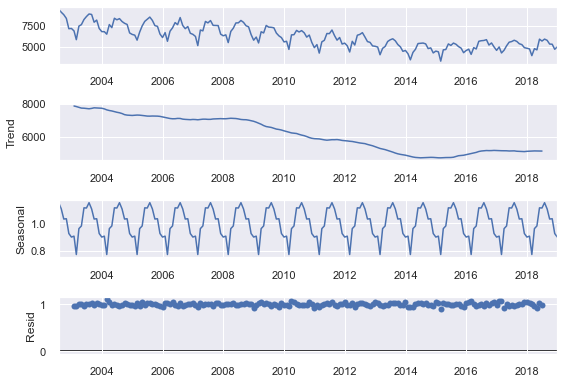

In [16]:
violent_decomp = seasonal_decompose(violent_ts_train, 'mul')
violent_decomp.plot()
pyplot.show()

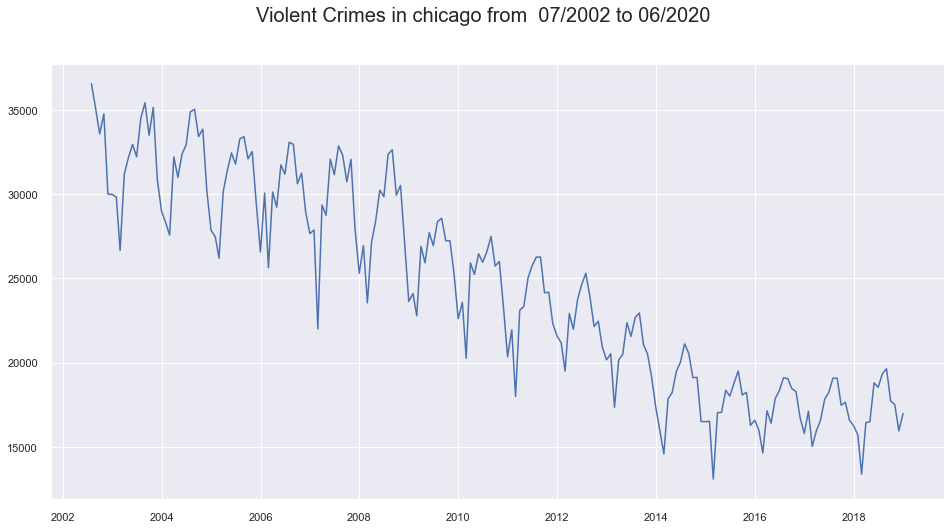

In [17]:
#Plot the nonviolent crime data
nonviolent_df = crime_df[crime_df['is_violent'] == 0]
nonviolent_ts_test = to_timeseries(nonviolent_df).loc['2002-07-31':'2020-06-30']
nonviolent_ts_train = to_timeseries(nonviolent_df).loc['2002-07-31':'2018-12-31']

plt.figure(figsize = (16, 8))
plt.suptitle('Violent Crimes in chicago from  07/2002 to 06/2020', fontsize = 20)
plt.plot(nonviolent_ts_train) #plot ts of violent crimes

Similarily, there is a trend and seasonality in the nonviolent crime data. Once again we will automatically decompose the data.

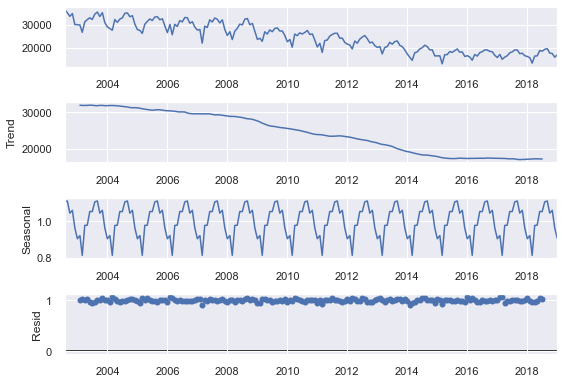

In [18]:
nonviolent_decomp = seasonal_decompose(nonviolent_ts_train, 'multiplicative')
nonviolent_decomp.plot()
pyplot.show()

Since there is both a trend and seasonality in the data, I will use triple exponential, or Holt-Winter, smoothing. <mark> ExponentialSmoothing </mark> has a variety of parameters that can be tuned for more accurate modeling including <b>trend, damped, seasonal, seasonal periods</b>. Python also allows you optimize the model through the additional <b> use_boxcox </b> and <b> remove_bias</b> parameters when using <mark>.fit</mark> to train the model.

In order to tune the parameters, I will wrap a walk forward validation method in a user-defined tuning function <mark> es_tune </mark> to identify the model parameters that produce the lowest root mean squared error.   

In [19]:
#build exponential smoothing
def es_fitting(df, config, n_future):
    ts = df
    t, d, s, p, b, r = config #parameters
    model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    es_fit = model.fit(optimized = True, use_boxcox=b, remove_bias=r)
    yhat = es_fit.predict(len(ts), len(ts) + n_future) #n_future is the number of months forecasted in the future
    return(yhat)


def rmse_calc(actual, predicted):
    return math.sqrt(metrics.mean_squared_error(actual, predicted))

#Walk forward validation method from: https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/
#n_test is the number of points (months in this example) to be used as the test data set
def walk_forward_validation(df, n_test, cfg):
    predictions = list()
    
    # split dataset
    train, test = df[:-n_test], df[-n_test:]
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = es_fitting(df, cfg, n_future) 
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = rmse_calc(test, predictions)
    return(error)

#Tune the parameters by testing all possible combinations of parameters and identifying the lowest MRSE
def es_tune(df, n_test, n_future):
    param_combos = [] 
    
    #Lists of parameters
    t = ['add', 'mul']
    d = [True, False]
    s = ['add', 'mul']
    p = [12]
    b = [True, False]
    r = [True, False]
    
    # create nested list of all combinations of parameters
    for x in itertools.product(t, d, s, p, b, r):
        param_combos.append(x)

    errors = {} 
  
    for k,v in enumerate(param_combos):
        try:
            errors.update({k:walk_forward_validation(df, n_test, v)}) #update the dictionary with key(iteration)/value(MRSE) pairs
        except Exception as e: 
            pass
    
    min_mrse = min(errors.items(), key=itemgetter(1)) #get the key/value pair with the lowest value
    min_index = min(errors, key=errors.get) 
    
    for k,v in enumerate(param_combos): #enumerate parameter combos and match index value with minimum mrse index value
        if k == min_index: 
            best_param = v
            
            
    return(min_mrse, best_param) #return the "best" set of parameters and the associated MRSE

In [20]:
#Tune the parameters to identify the "best" set of parameters for the violent and non-violent crime datasets
n_test = 12
n_future = 0

violent_params = es_tune(violent_ts_train.to_numpy(), n_test, n_future)
nonviolent_params = es_tune(nonviolent_ts_train.to_numpy(), n_test, n_future)

print('The set of parameters that produced the lowest mrse for the model fit with the violent crime data is', violent_params[1], 'The MRSE is', violent_params[0][1])

print('The set of parameters that produced the lowest mrse for the model fit with the nonviolent crime data is', nonviolent_params[1], 'The MRSE is', nonviolent_params[0][1])

The set of parameters that produced the lowest mrse for the model fit with the violent crime data is ('mul', True, 'add', 12, False, False) The MRSE is 655.8844684025638
The set of parameters that produced the lowest mrse for the model fit with the nonviolent crime data is ('add', True, 'mul', 12, False, False) The MRSE is 2069.9579352033147


From the output above, we can see that the parameters that produced the lowest MRSE for the model fit with the <b>violent crime</b> data are <b>'mul', True, 'add', 12, False, False </b>, which produced an MRSE of <b>  665.8 </b>. The parameters that produced the lowest MRSE for the model fit with the <b>nonviolent crime</b> data are <b>'add', True, 'mul', 12, False, False </b>, which yieled an MRSE of <b> 2069 </b>. 

The data used to fit these models spanned from 6/30/2002 to 12/31/2018. The complete chicago dataset contains up-to-date crime incidents. Using this information, I will visualize the general accuracy of this model in predicting the number of violent and non-violent crimes from 12/31/2018 to 6/31/2020 (~18 months). 

In [21]:
#Visualize the forecast
def es_forecast_check(ts_train, ts_test, start_date, stop_date, params, n_test, n_future, title):
    ts_train = ts_train
    ts_test = ts_test
    forecast = es_fitting(ts_test[:-18], params, n_future)
    
    plt.figure(figsize = (16, 8))
    plt.suptitle(title, fontsize = 20)
    plt.plot(ts_train.loc[start_date:stop_date], label = 'Historic')
    plt.plot(ts_test.loc[stop_date: ], label = 'Actual')
    plt.plot(forecast.loc[stop_date: ], label = 'Predicted')
    plt.legend(loc='best')
    return(plt)

<module 'matplotlib.pyplot' from 'C:\\Users\\jweber6\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

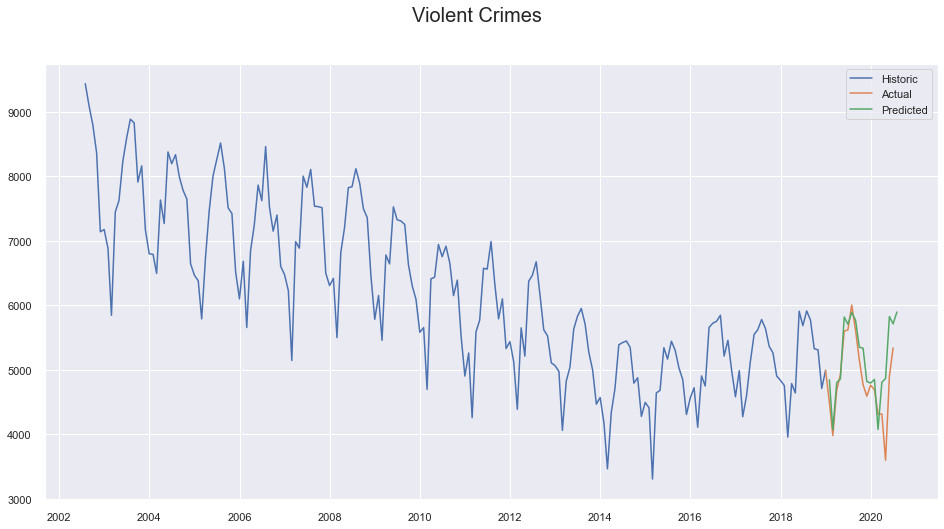

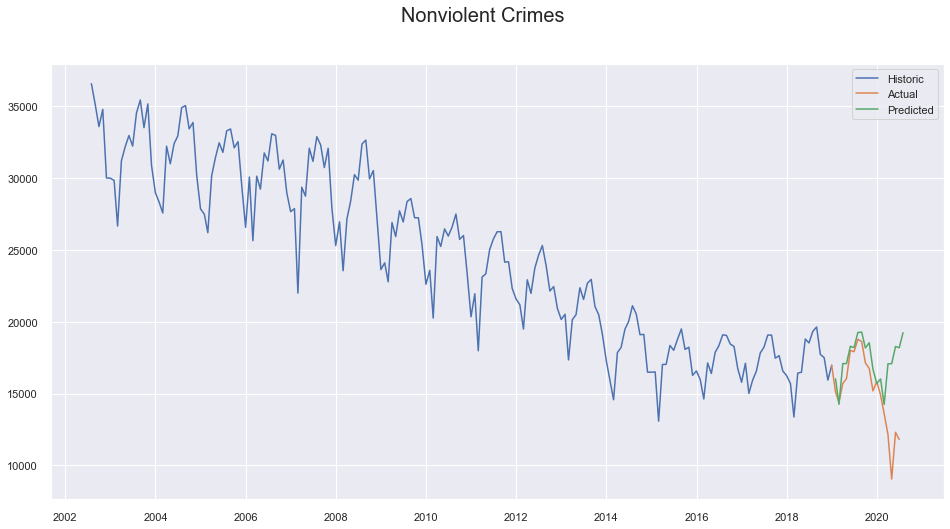

In [22]:
es_forecast_check(violent_ts_train, violent_ts_test, '2002-06-30', '2018-12-31', tuple(violent_params[1]), 12, 18, 'Violent Crimes')
es_forecast_check(nonviolent_ts_train, nonviolent_ts_test, '2002-06-30', '2018-12-31', tuple(nonviolent_params[1]), 12, 18, 'Nonviolent Crimes')

We can see from the plots above that the violent crime exponential smoothing model is much better at forecasting than the nonviolent crime model. This is also apparent when considering the RMSE values for the nonviolent exponential smoothing model (612.8) and the violent exponential smoothing model (3072). The RMSE indicates how close the observed data points are to the model's predicted values. Thus, the lower the RMSE, the closer the observed values are to the predicted values. The comparatively poor fit of the nonviolent crime model is likely due to the the abnormally large drop in nonviolent crimes caused by Covid-19.

The walk forward validation method combined with the parameter tuning function can help identify the best set of parameters for fitting an exponential smooththing model in python. This notebook provides a framework for the quick optimization of exponential smoothing for time-series analysis. 
